# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Открытие и анализ анных

In [ ]:
#conda install -c conda-forge lightgbm

#pip install lightgbm

#!pip install sweetviz

In [ ]:
#conda install -c conda-forge catboost

In [1]:
# импорт небходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sb
import sweetviz as sv
from sklearn.preprocessing import OrdinalEncoder
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from catboost import Pool, cv
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
import time
from sklearn.dummy import DummyRegressor
import re

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Открытие таблицы с данными
try:
    data=pd.read_csv(r'C:\data\autos.csv', sep=',')
    pd.set_option('display.max_columns', None) 
except:
    data=pd.read_csv('/datasets/autos.csv', sep=',')
    pd.set_option('display.max_columns', None)


#### Оценка и визуализация данных 

*Предварительный анализ данных таблицы проведу с помощью библиотеки Sweetviz*

                                             |                                             | [  0%]   00:00 ->…


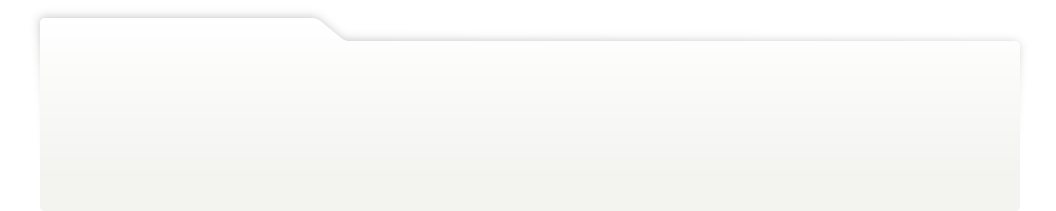
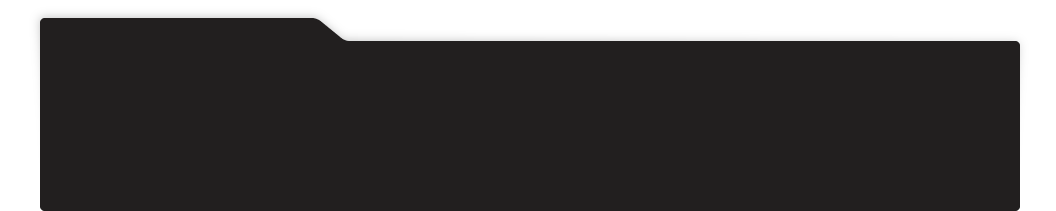
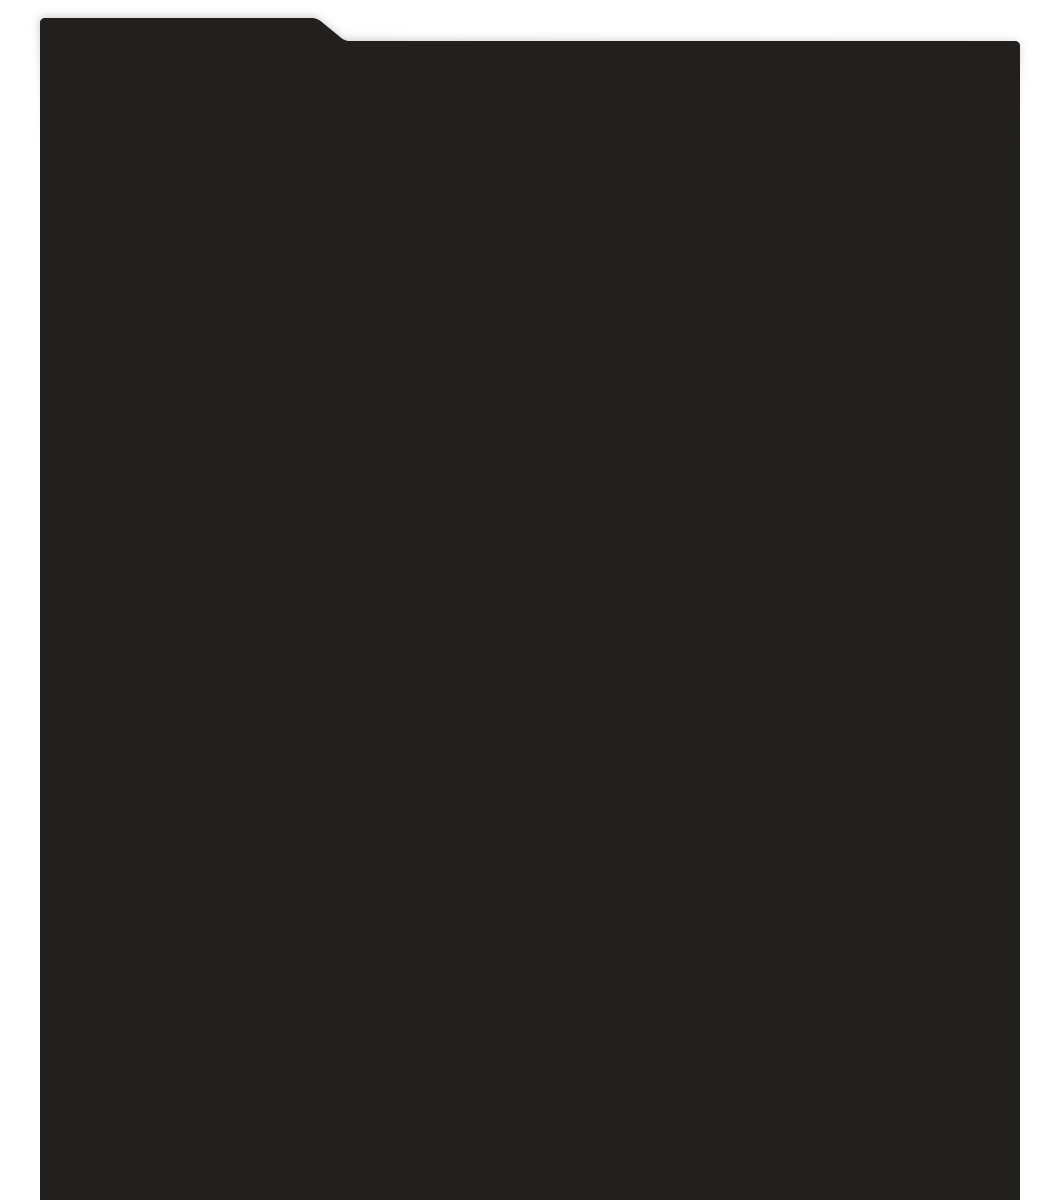
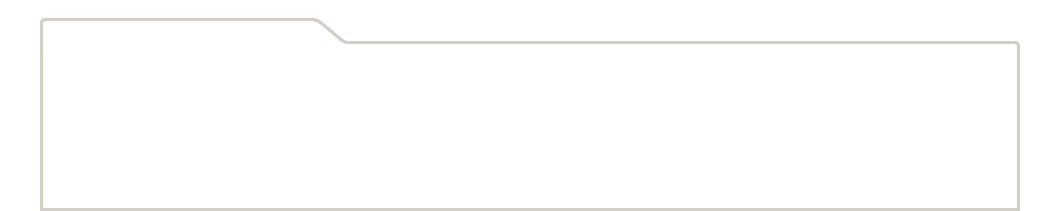
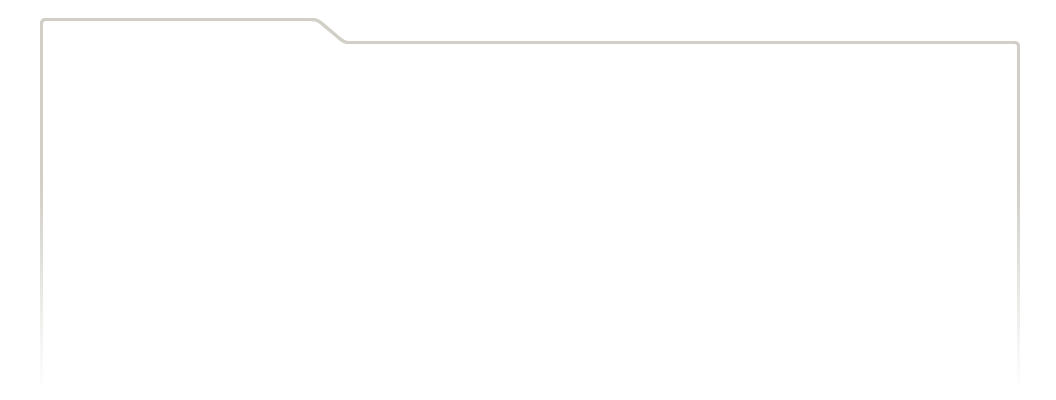
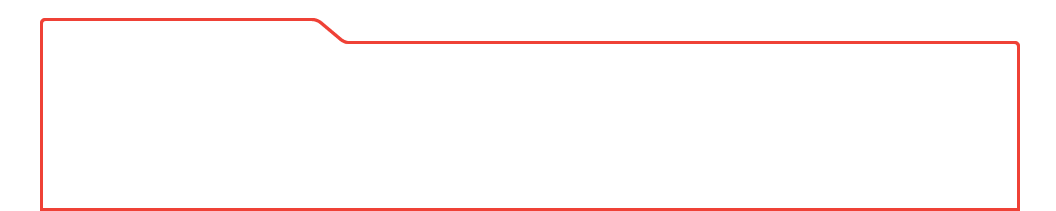
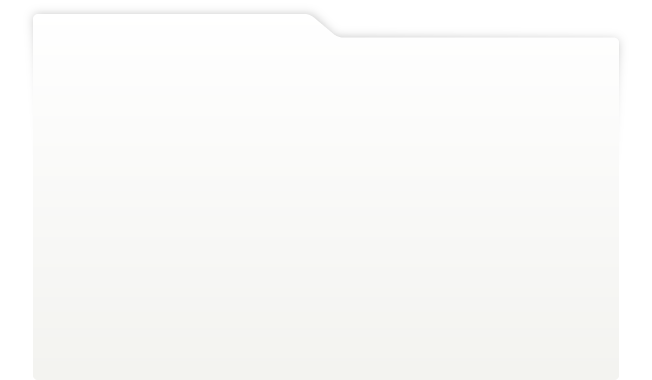
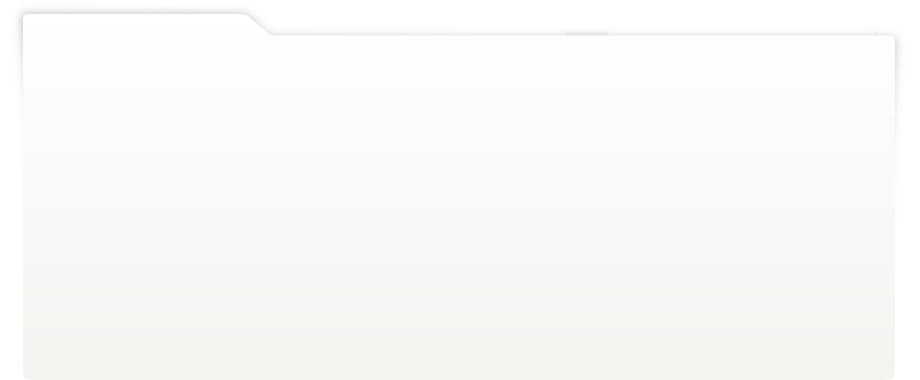
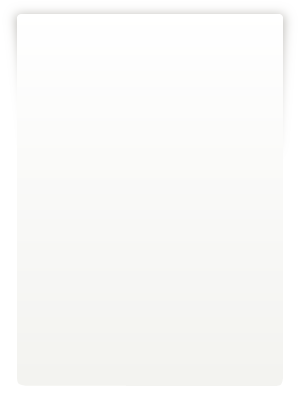
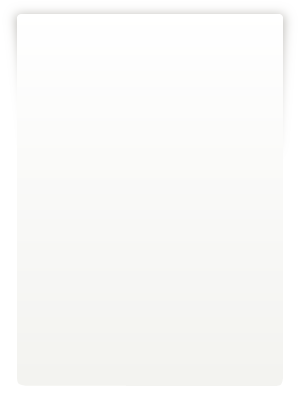
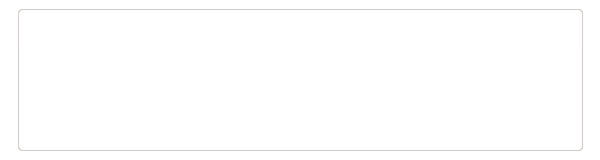
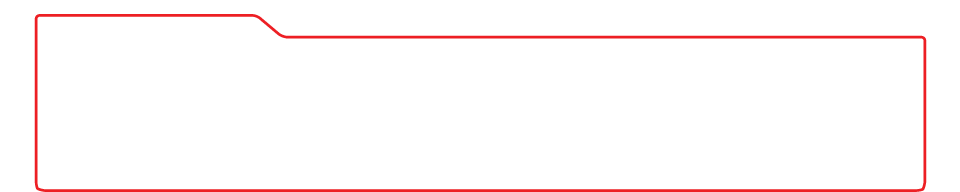
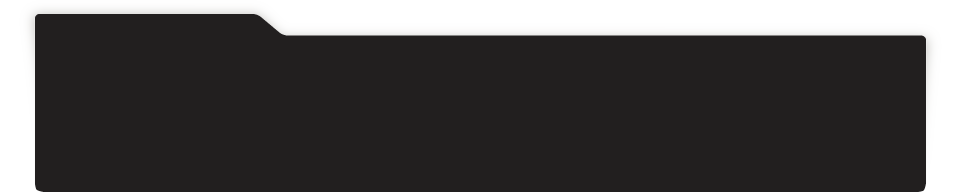
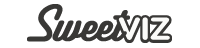
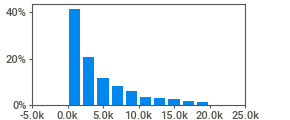
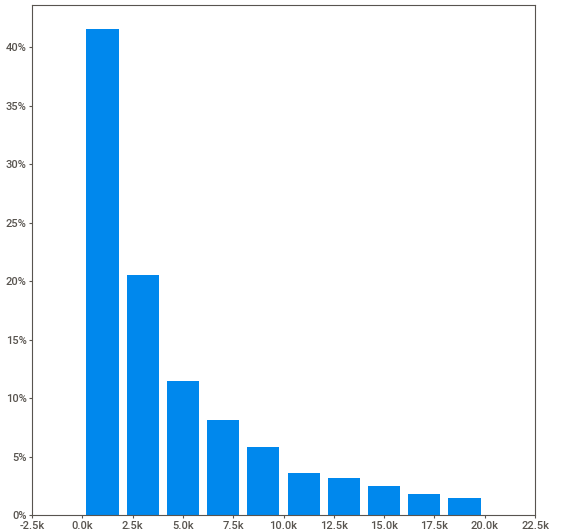
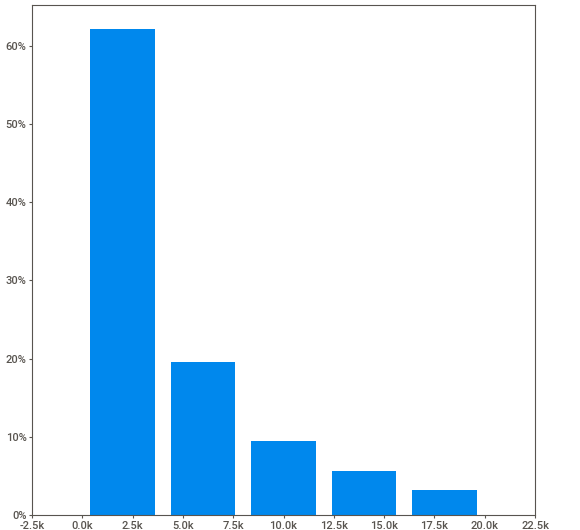
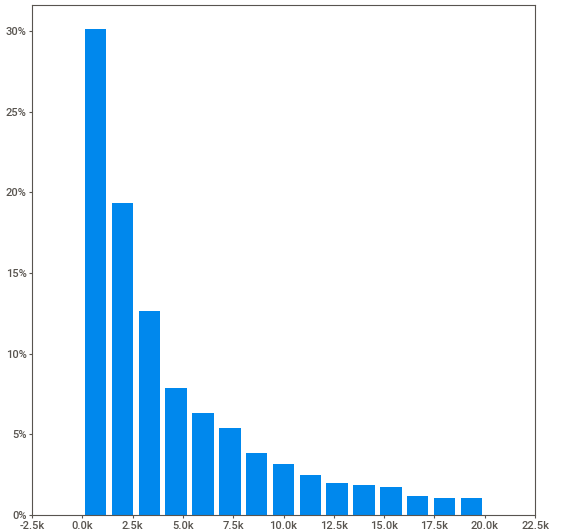
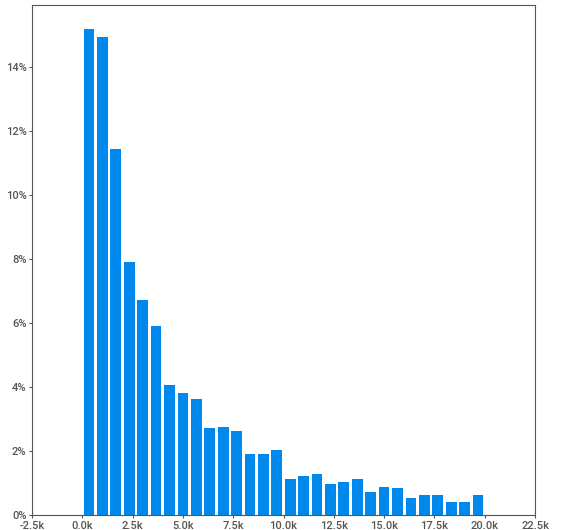
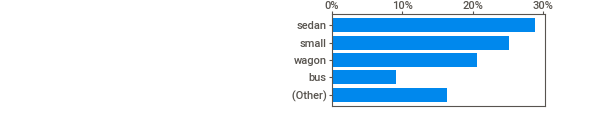
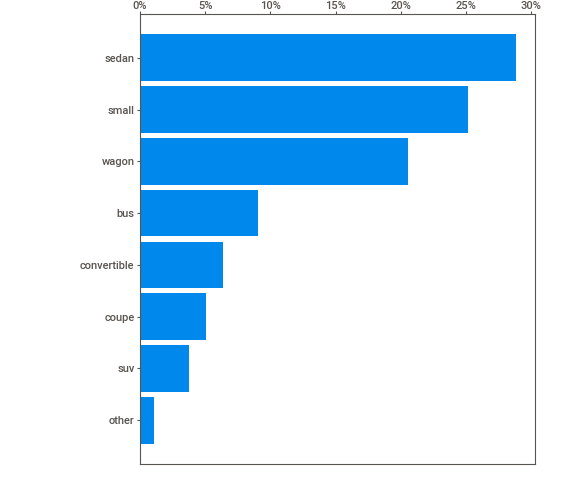
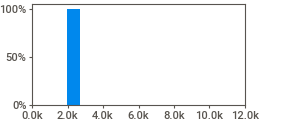
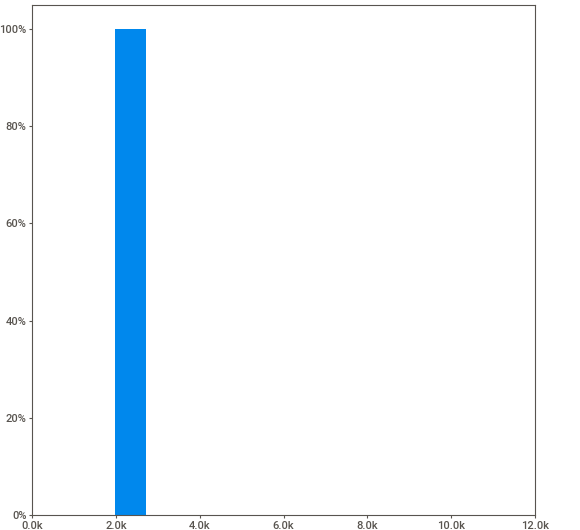
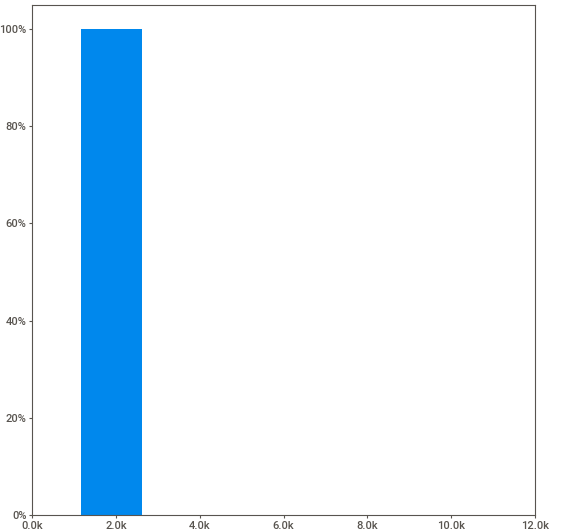
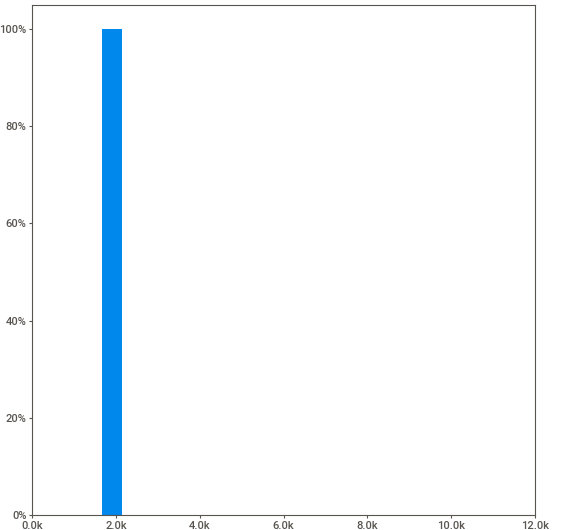
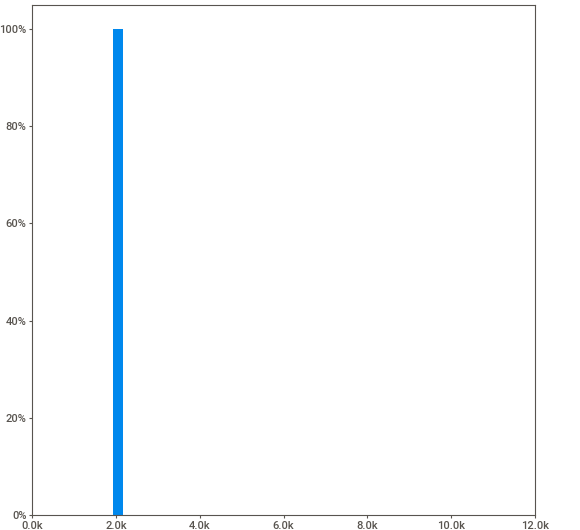
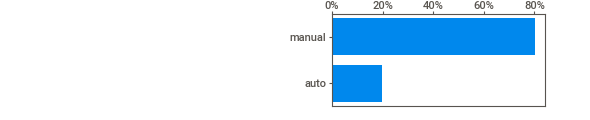
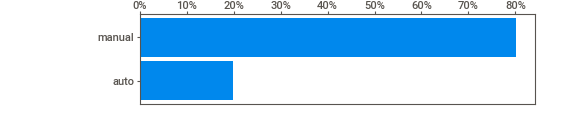
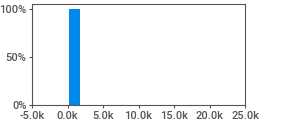
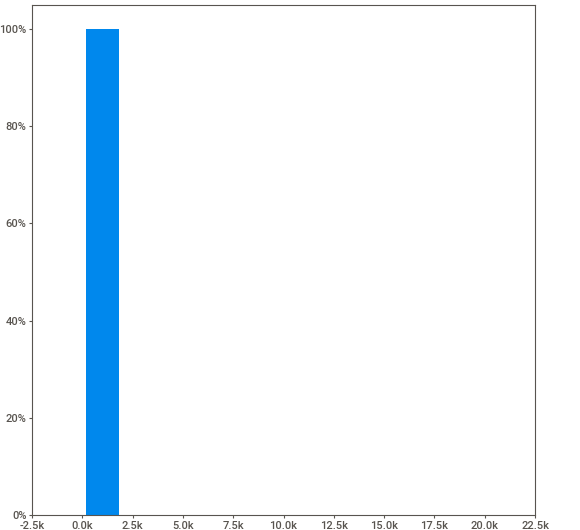
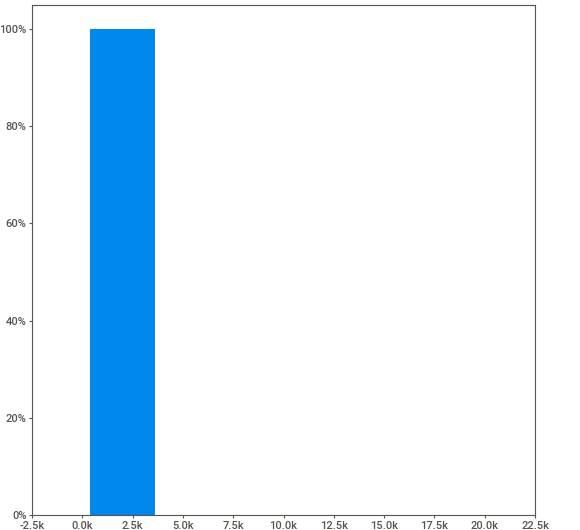
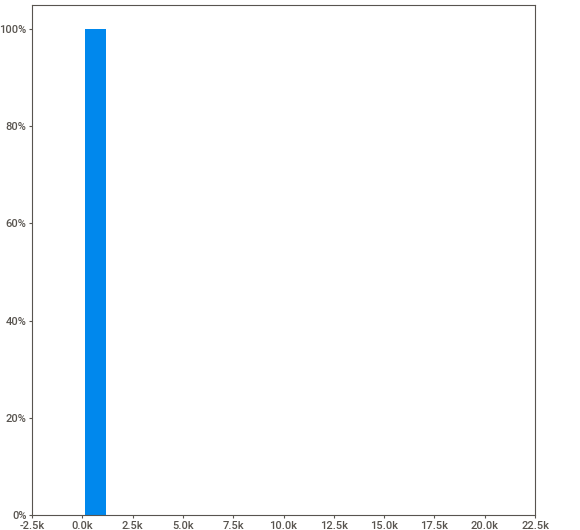
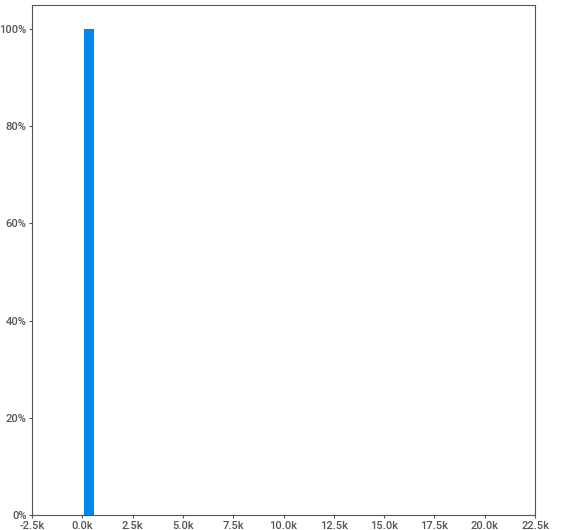
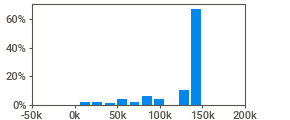
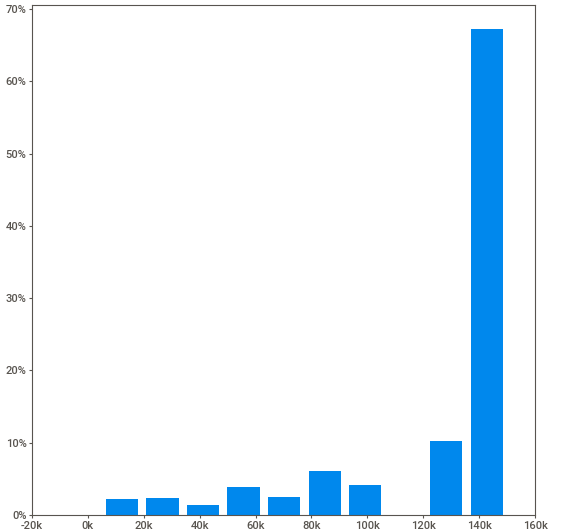
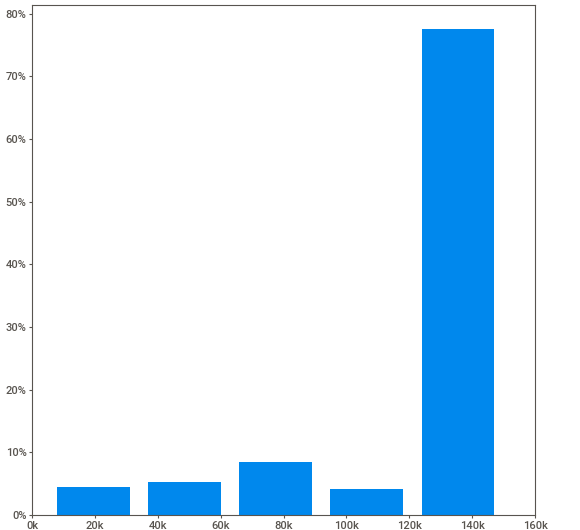
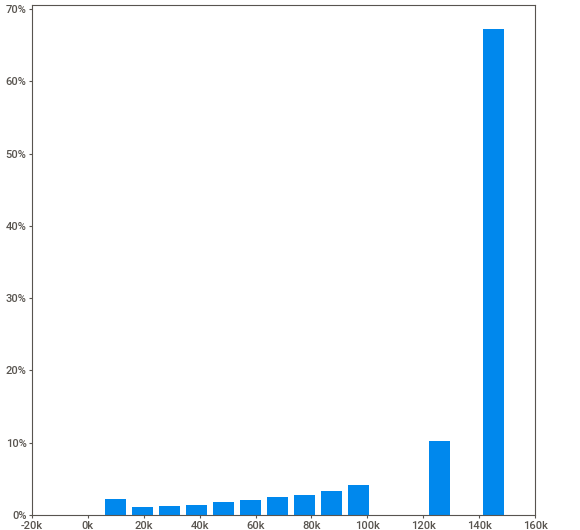
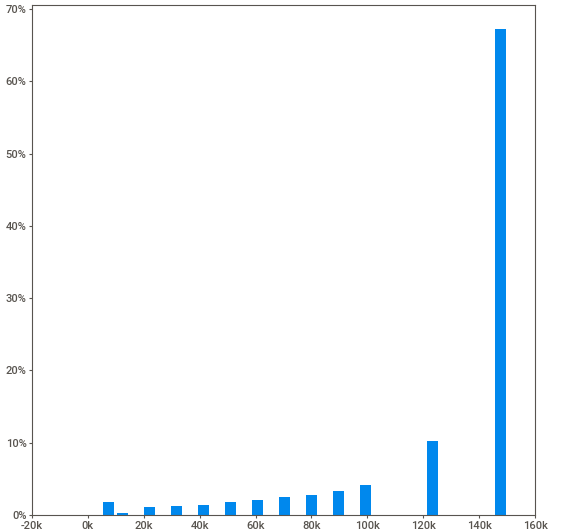
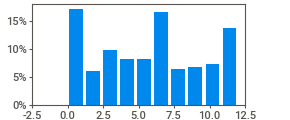
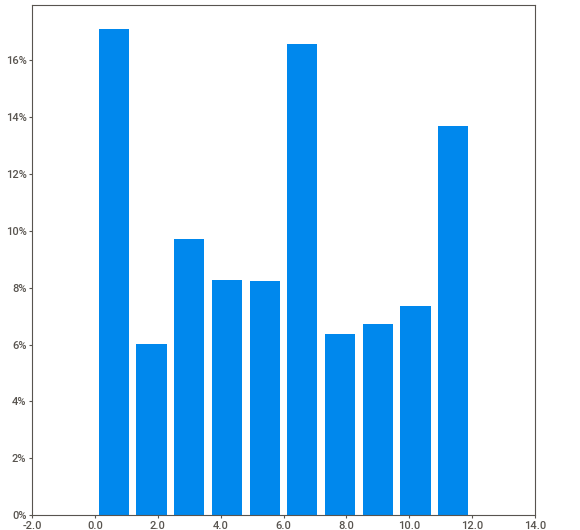
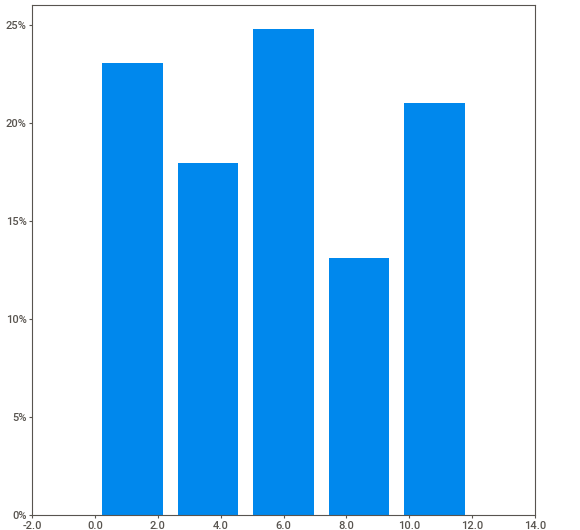
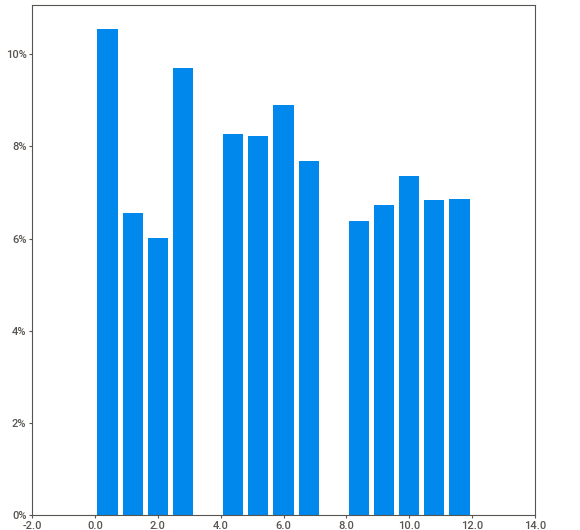
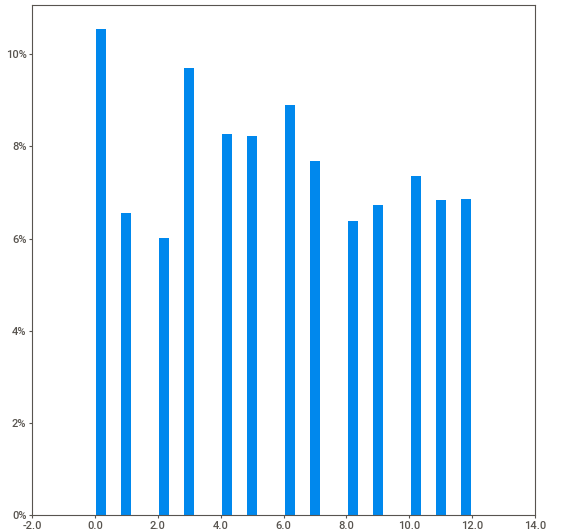
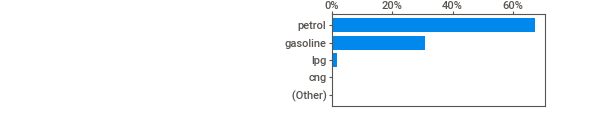
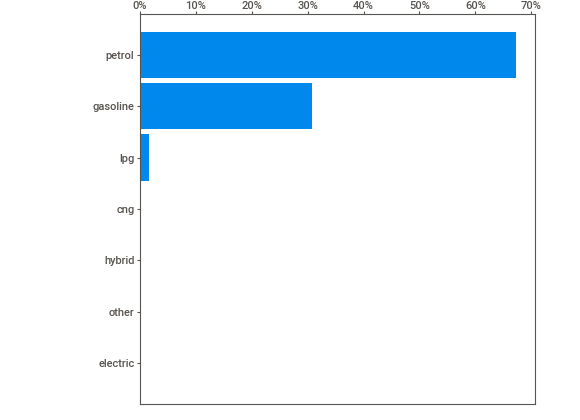
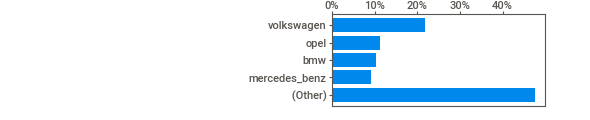
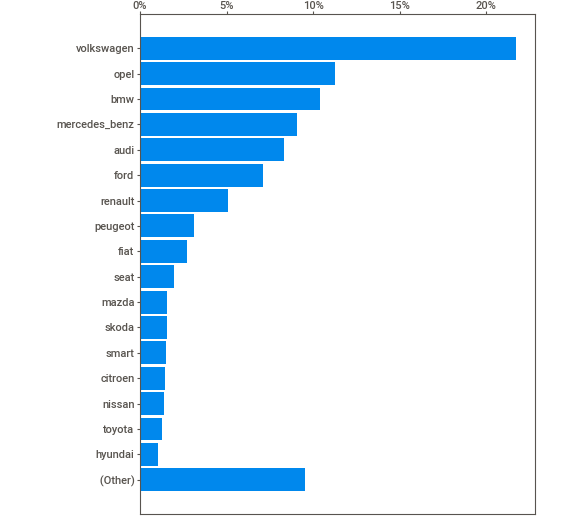
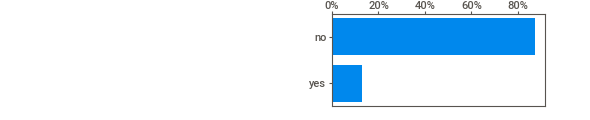
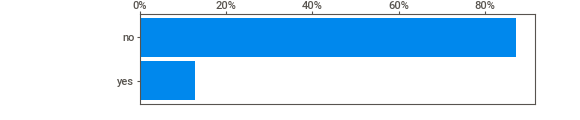
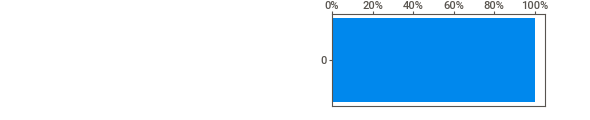
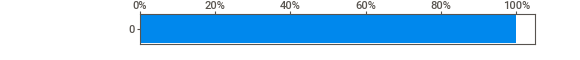
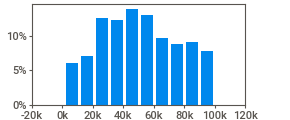
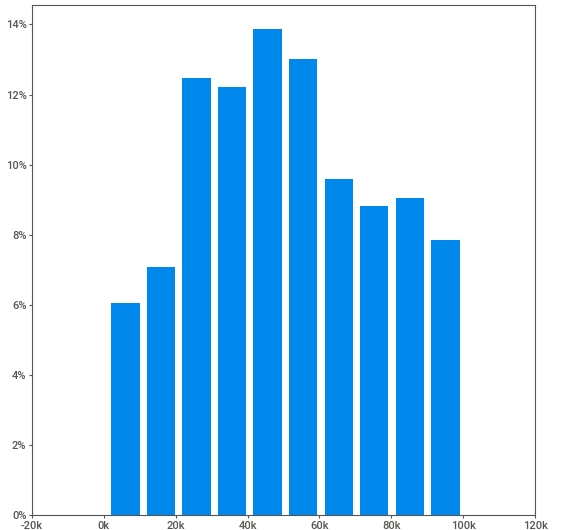
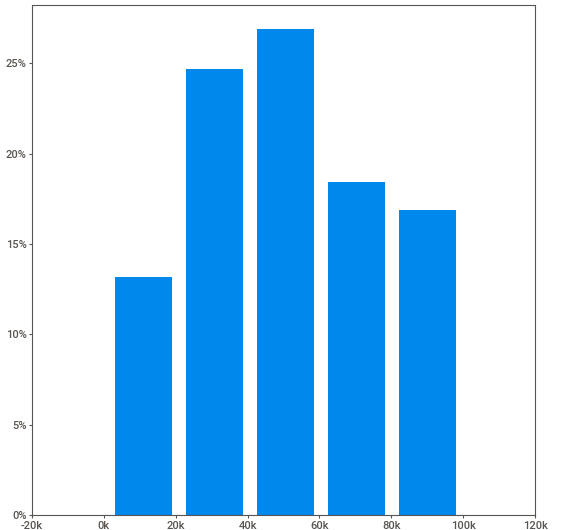
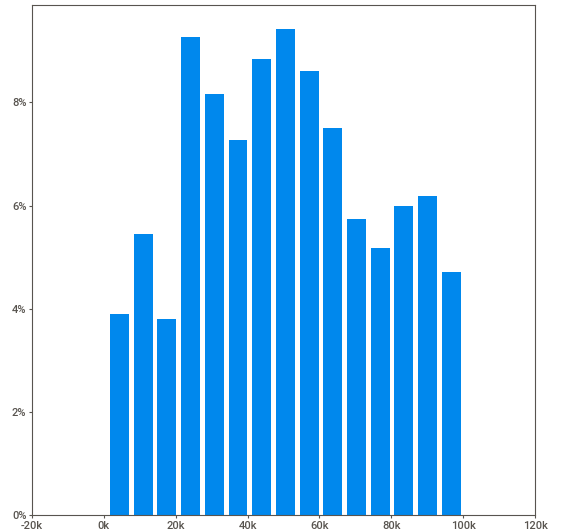
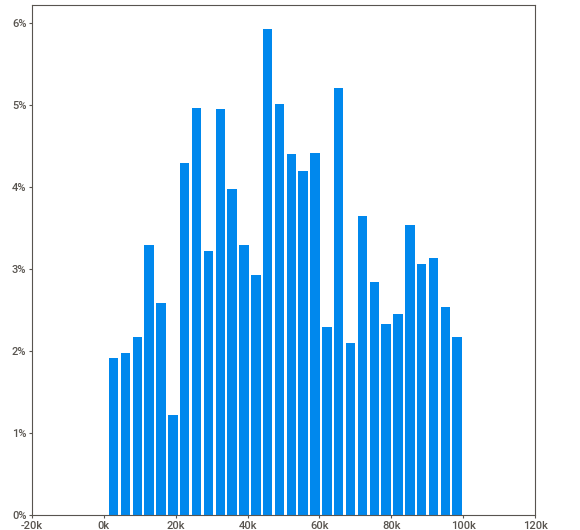
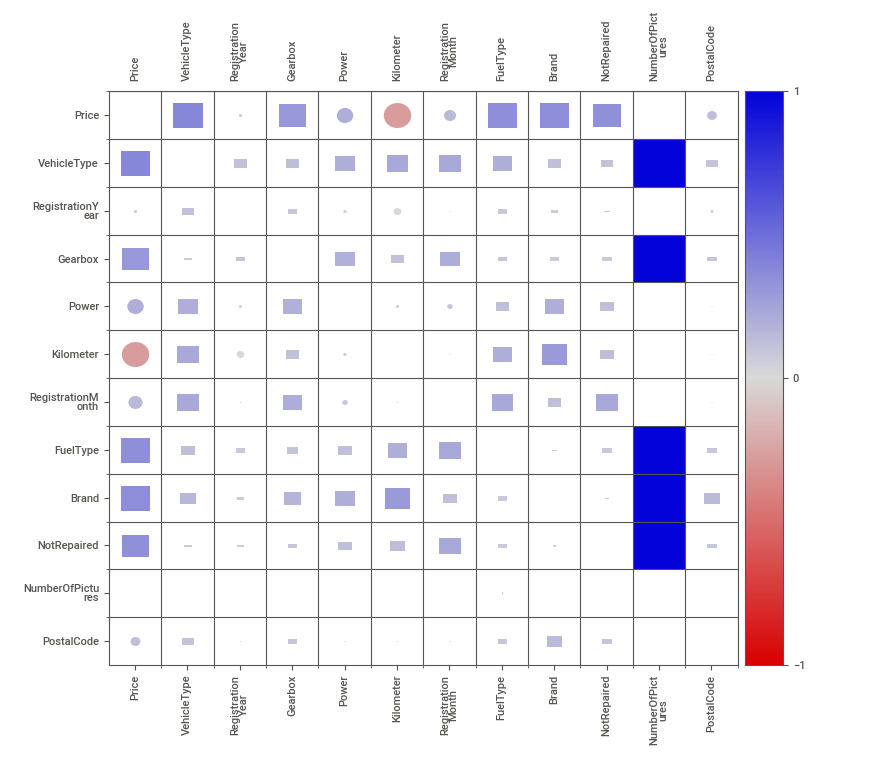
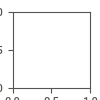

In [3]:
my_report = sv.analyze(data, pairwise_analysis = 'on')
my_report.show_notebook(h='full')

#### Взаимозависомость признаков

In [4]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


<AxesSubplot:>

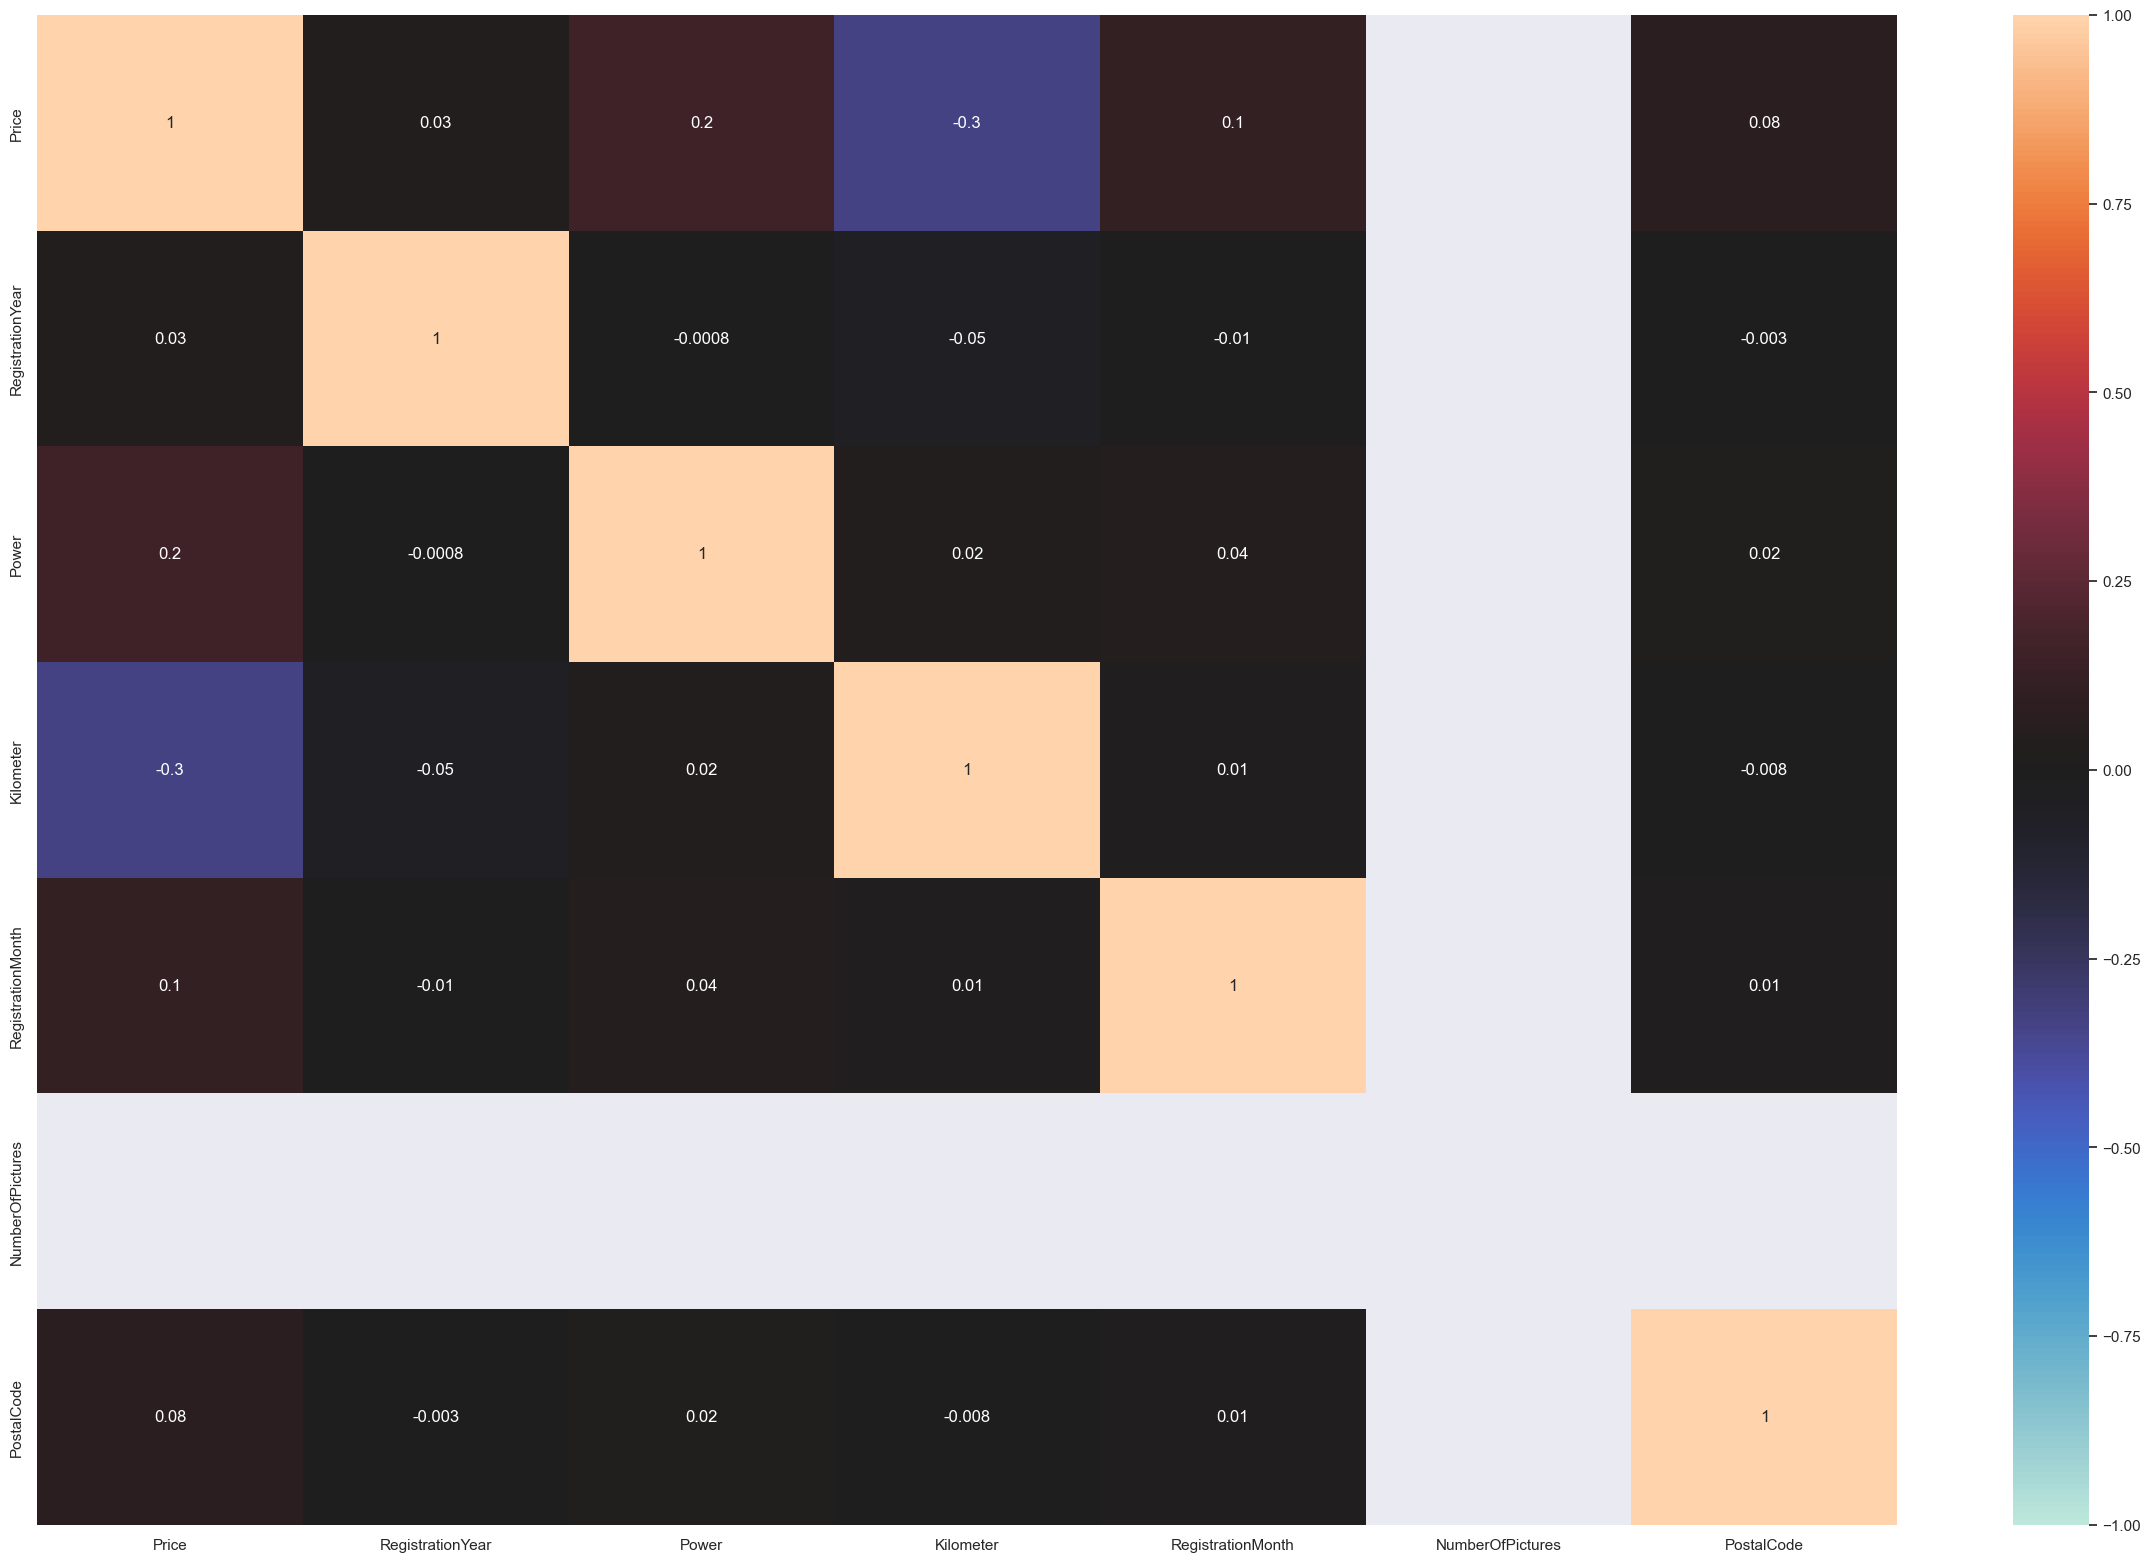

In [5]:
#Визцализация корреляции    
sb.set(rc = {'figure.figsize':(30,20)})
sb.heatmap(data.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0)


### Удаление столбцов

*Предположу, что не все признаки нужны для обучения модели. Считаю, тто столбцы `DateCrawled`, `PostalCode`, `NumberOfPictures`, `DateCreated` и `LastSeen` не имеют важности для модели. Удалю их. Колонку с датой создания акеты оставлю, постокоьку считаю, что длительность "висения" объявления на сайте влияет на стоимость автомобиля.*

In [6]:
new_data=data.drop(['DateCrawled', 'PostalCode', 'LastSeen','NumberOfPictures','DateCreated'], axis=1)
new_data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


### Предварительная обработка

#### Удалеие пропусков

Обработаю пропуски следующим образом: все категориальные данныйе с пропускаи заменю на `unknown`.

In [7]:
# Так как пропуски только в категориаьных данных, применяю fillna ко всей таблице сразу
new_data.fillna('unknown', inplace=True)
new_data.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
dtype: int64

In [8]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        354369 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            354369 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              354369 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           354369 non-null  object
 9   Brand              354369 non-null  object
 10  NotRepaired        354369 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


#### Удалеие дубликатов

In [9]:
#Поиск дубликатов
new_data.duplicated().sum()

27543

In [10]:
# Удаление дубликатов
new_data=new_data.drop_duplicates()
new_data.duplicated().sum()

0

In [11]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326826 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              326826 non-null  int64 
 1   VehicleType        326826 non-null  object
 2   RegistrationYear   326826 non-null  int64 
 3   Gearbox            326826 non-null  object
 4   Power              326826 non-null  int64 
 5   Model              326826 non-null  object
 6   Kilometer          326826 non-null  int64 
 7   RegistrationMonth  326826 non-null  int64 
 8   FuelType           326826 non-null  object
 9   Brand              326826 non-null  object
 10  NotRepaired        326826 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.9+ MB


#### Выбросы

Text(0.5, 0, 'Цена (евро)')

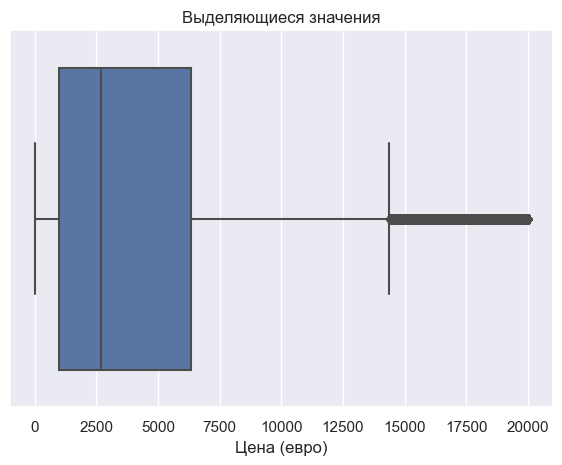

In [12]:
#определение выделяющихся значений цены
sb.set(rc = {'figure.figsize':(7,5)})
sb.boxplot(x=new_data['Price'])
plt.title('Выделяющиеся значения')
plt.xlabel("Цена (евро)")

*В колонке с данными о цене выделяющиеся значения убирать не буду, поскольку цена на машину может быть разной и зависеть как от объективных, так и субъективных (желание продавца) факторов*

Text(0.5, 0, 'Год регистрации')

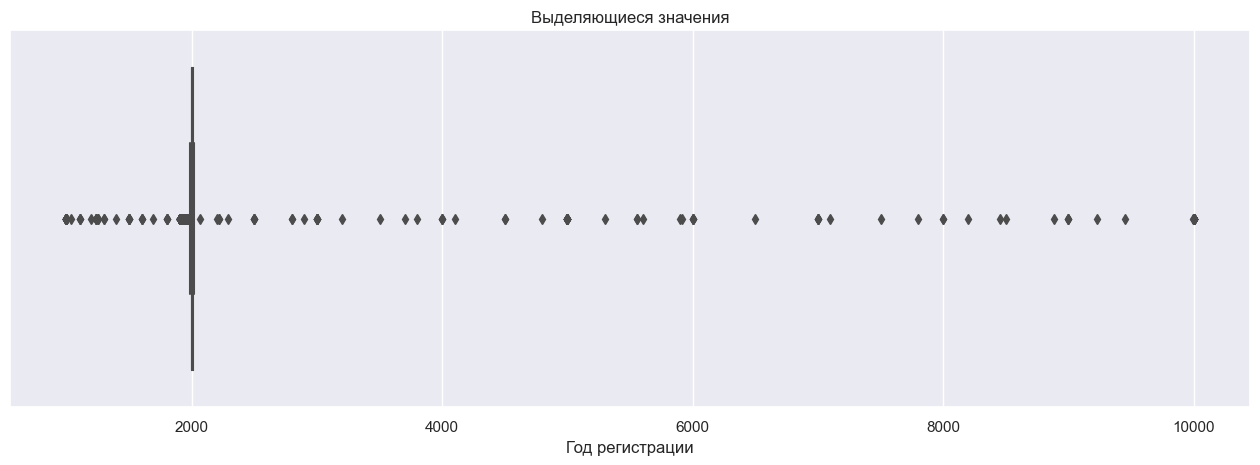

In [13]:
#определение выделяющихся значений года выпуска
sb.set(rc = {'figure.figsize':(16,5)})
sb.boxplot(x=new_data['RegistrationYear'])
plt.title('Выделяющиеся значения')
plt.xlabel("Год регистрации")

*Колонка с годом выпуска содержит выделяющиеся значения. Предположу, что они ошибочны, поскольку регистрация автомобиля позже текущего периода невозможна. Также невозможна регистрация в 1 году. Исходя из данных анализа ( библиотека Sweetviz ) удалю значения, которые существенно меньше квантиля 5% (1992) и существенно больше - 95% (2016). Оставлю в таблице сведения об автомобилях, зарегистрированных в период с 1980 по 2022*

Text(0.5, 0, 'Мощность')

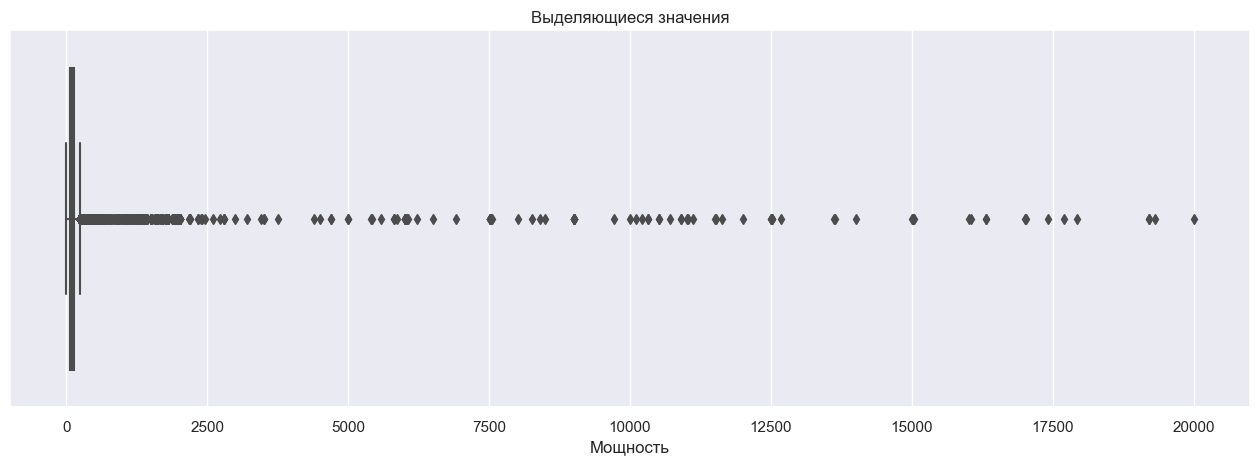

In [14]:
#определение выделяющихся значений мощности
sb.set(rc = {'figure.figsize':(16,5)})
sb.boxplot(x=new_data['Power'])
plt.title('Выделяющиеся значения')
plt.xlabel("Мощность")

*Исходя из сведений доступных источников, мощность двигателя не превышает 1650 л.с. Так как я не специалист в данной отрасли и других данных не нашла, удалю сведения о автомобилях с мощностью двигателя свыше 2000 л.с.*

Text(0.5, 0, 'Километраж')

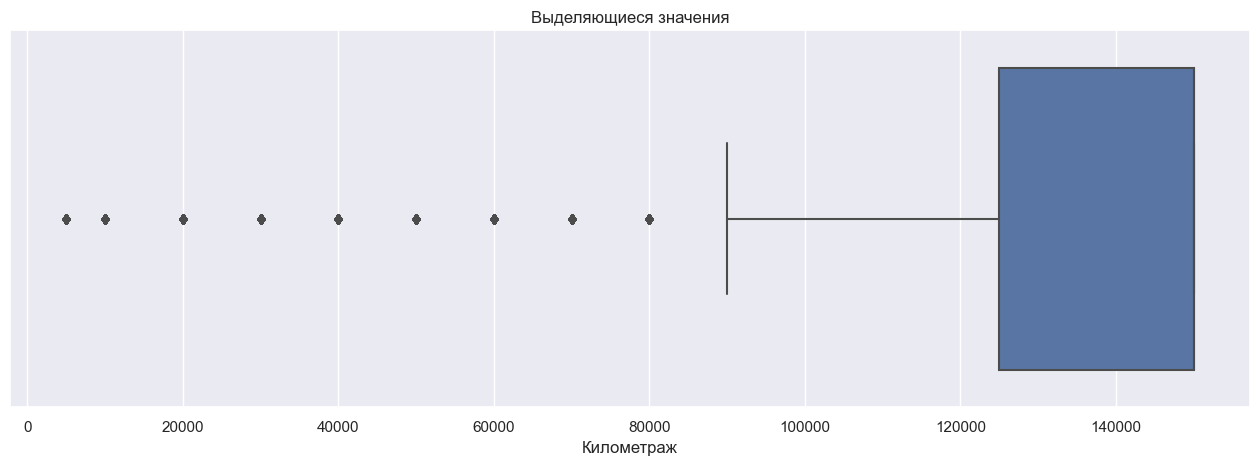

In [15]:
#определение выделяющихся значений километража
sb.set(rc = {'figure.figsize':(16,5)})
sb.boxplot(x=new_data['Kilometer'])
plt.title('Выделяющиеся значения')
plt.xlabel("Километраж")

*В этой колонке выбросы удалять не буду, поскольку пробег может быть разным ( в т.ч. его могли "скрутить")*

**Удалю выбросы данных, согласно приведённым предположениям**

In [16]:
data_clean=new_data.query('(1980<RegistrationYear<2022)and(2000>Power)')
data_clean.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [17]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322732 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              322732 non-null  int64 
 1   VehicleType        322732 non-null  object
 2   RegistrationYear   322732 non-null  int64 
 3   Gearbox            322732 non-null  object
 4   Power              322732 non-null  int64 
 5   Model              322732 non-null  object
 6   Kilometer          322732 non-null  int64 
 7   RegistrationMonth  322732 non-null  int64 
 8   FuelType           322732 non-null  object
 9   Brand              322732 non-null  object
 10  NotRepaired        322732 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.5+ MB


Text(0.5, 0, 'Год регистрации')

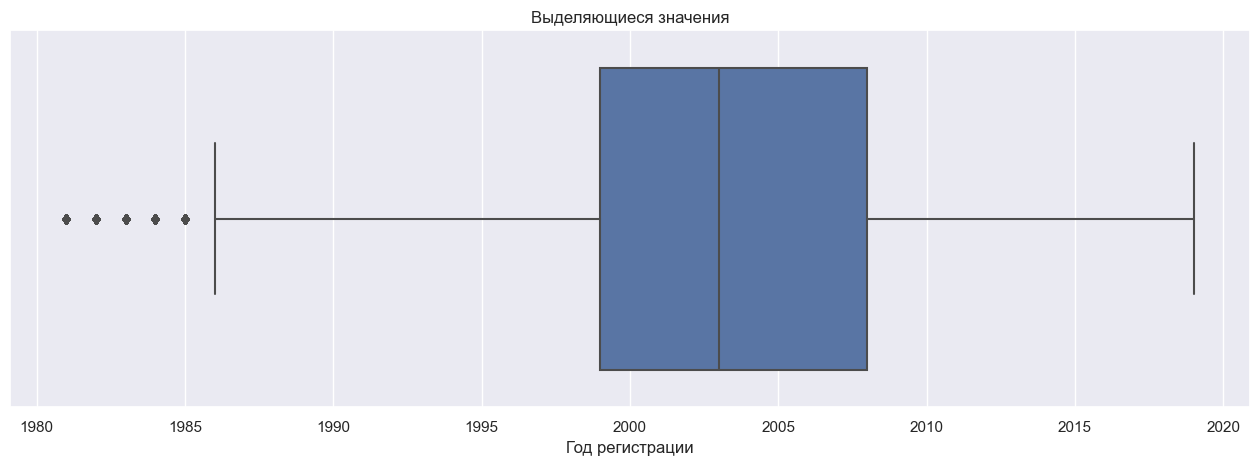

In [18]:
#определение выделяющихся значений мощности
sb.set(rc = {'figure.figsize':(16,5)})
sb.boxplot(x=data_clean['RegistrationYear'])
plt.title('Выделяющиеся значения')
plt.xlabel("Год регистрации")

Text(0.5, 0, 'Мощность')

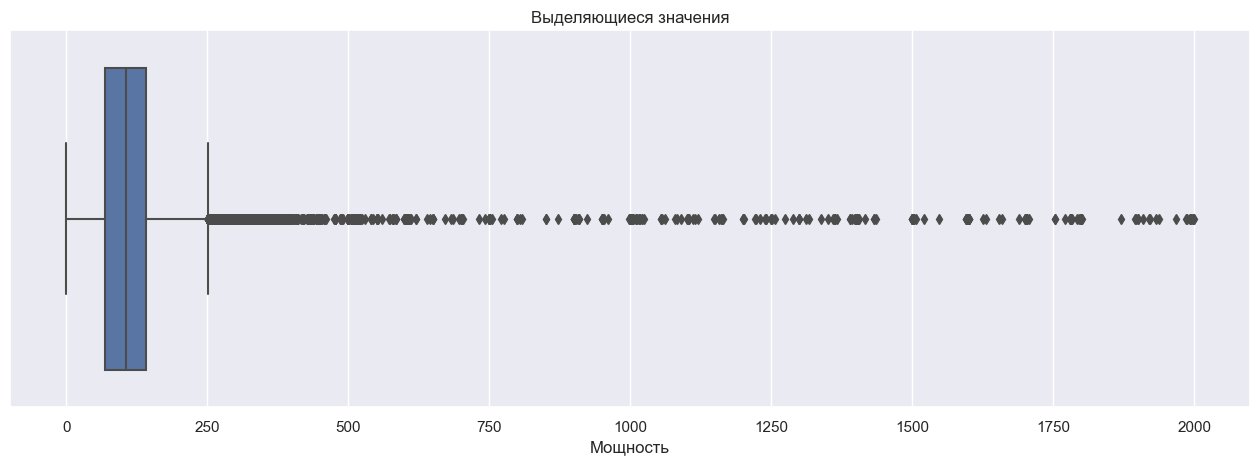

In [19]:
#определение выделяющихся значений мощности
sb.set(rc = {'figure.figsize':(16,5)})
sb.boxplot(x=data_clean['Power'])
plt.title('Выделяющиеся значения')
plt.xlabel("Мощность")

In [20]:
#Это действие необходимо для избежания ошибок в работе LightGBM и CatBoost
data_clean = data_clean.rename(columns = lambda  x:re.sub('[^A-Za-z0-9_]+', '', x))

### Работа с категориальными знчениями

*Категориальные данные не подходят для работы некоторых моделей, поэтому их необходимо преобрабозвать.<br>
Применю два вида кодировки: ОНЕ для линейных моделей (параметр drop_first=True не использовала, поскольку посчитала, что исчезновение одного признака изменит качество данных) и Ordinal Encoding для "деревьев".*

In [21]:
#Преобразование категориальных данных с помощию ОНЕ
data_ohe = pd.get_dummies(data_clean)
data_ohe.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,Gearbox_auto,Gearbox_manual,Gearbox_unknown,Model_100,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_unknown,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown,Brand_alfa_romeo,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant

In [22]:
#Удалю стобцы, содержащие пропущенные данные, полученные после преоразования
data_ohe=data_ohe.drop(['VehicleType_unknown','Gearbox_unknown', 'Model_unknown', 'FuelType_unknown', 'NotRepaired_unknown'], axis=1)
data_ohe.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_auto,Gearbox_manual,Model_100,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_alfa_romeo,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no,NotRepaired_yes
0,480,

In [23]:
# Создание таблицы, которая будет содержать даные после преоразования с помощью OrdinalEncoder
data_encoder=data_clean.copy()

In [24]:
#Преобразование категориальных данных с помощью OrdinalEncoder
encoder = OrdinalEncoder()
data_encoder[['VehicleType', 'Gearbox', 'Model', 'Brand','NotRepaired','FuelType']]=encoder.fit_transform(data_clean[['VehicleType', 'Gearbox', 'Model',  'Brand','NotRepaired', 'FuelType']])
data_encoder.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,7.0,1993,1.0,0,116.0,150000,0,6.0,38.0,1.0
1,18300,2.0,2011,1.0,190,226.0,125000,5,2.0,1.0,2.0
2,9800,6.0,2004,0.0,163,117.0,125000,8,2.0,14.0,1.0
3,1500,5.0,2001,1.0,75,116.0,150000,6,6.0,38.0,0.0
4,3600,5.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0


*Таблицу `new_data` оставлю без изменения, поскольку не для всех моделей приемлемо преобразование категориальнхданных на этом этапе*.

### Вывод

Проанализировав представленные данные выполнила следующее:<br>
1. Пропуски в колонках с категорильными значениями заменила значением `unknown`. Удалять пропущенные значения не стала, поскольку их количество в некоторых столбцах превышает 10%. Там, где их меньше также не удаляла, посчитав нецелесообразным.
2. Преобразовала категориальые занчения в цифроые для последующей корректной работы моделей.
3. Удалила дубликаты.<br>
4. Удалила выдающиеся значения в признаках, содержащих мощность и год регистрации.<br>
Сильной зависимости признаков не обнаружено.

## Анализ моделей

### Подготовка данных для моделей

**Выделение выборок для линейных моделей**

In [25]:
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(
    data_ohe.drop('Price', axis=1), data_ohe.Price, test_size=0.25, random_state=12345)

display('Размер признаков тренировочной выборки', features_train_ohe.shape)
display('Размер признаков тестовой выборки', features_valid_ohe.shape)
target_valid_ohe.shape

'Размер признаков тренировочной выборки'

(242049, 311)

'Размер признаков тестовой выборки'

(80683, 311)

(80683,)

**Выделение выборок для моделей на основе деревьев**

In [26]:
features_train_encoder, features_valid_encoder, target_train_encoder, target_valid_encoder = train_test_split(
    data_encoder.drop('Price', axis=1), data_encoder.Price, test_size=0.25, random_state=12345)

display('Размер признаков тренировочной выборки', features_train_encoder.shape)
display('Размер признаков тестовой выборки', features_valid_encoder.shape)
target_valid_encoder.shape

'Размер признаков тренировочной выборки'

(242049, 10)

'Размер признаков тестовой выборки'

(80683, 10)

(80683,)

**Выделение выборок для моделей, работающих с категориальными данными**

In [27]:
features=data_clean.drop('Price', axis=1)
target=data_clean['Price']

features_train, features_valid, target_train, target_valid = train_test_split(
    data_clean.drop('Price', axis=1), data_clean.Price, test_size=0.25, random_state=12345)

display('Размер признаков тренировочной выборки', features_train.shape)
display('Размер признаков тестовой выборки', features_valid.shape)
target_valid.shape

'Размер признаков тренировочной выборки'

(242049, 10)

'Размер признаков тестовой выборки'

(80683, 10)

(80683,)

**Необходимые функции**

In [28]:
# функия для расчёта метрики
def rmse (target_valid, predictions):
    return np.sqrt(mean_squared_error(target_valid, predictions))

In [29]:
score = make_scorer(rmse,greater_is_better=False)

In [30]:
# функция для определения времени обучения модели
def time_fit (model, features, target):
    start = time.time()
    model.fit(features, target)
    end = time.time()
    return end - start
# В тех случаях, когда модель обучается очень долго или требуются дополнительные параметры,
#функцию применять не буду, а воспользуюсь кодом внутри кода 

In [31]:
# функция для определения времени предсказаний модели
def time_predict (model, features):
    start = time.time()
    model.predict(features)
    end = time.time()
    return end - start


*В тех случаях, когда модель обучается очень долго или требуются дополнительные параметры,функцию применять не буду, а воспользуюсь кодом внутри кода*

**Для анализа результатов всех моделей я создам таблицу метрик. После работы каждой модели буду выделять данные для таблицы с помощью функции**

In [32]:
# Для добавления метрик в таблицу c результатами работы моделей
def metrics(result, result_train,  learn_train, predict_train, predict_valid, model, data):
    data.loc[model, 'RMSE'] = result
    data.loc[model, 'RMSE_train'] = result_train
    data.loc[model, 'learn_train'] = learn_train
    data.loc[model, 'predict_train'] = predict_train
    data.loc[model, 'predict_valid'] = predict_valid
    return data

In [33]:
# Таблица для сравнения результатов работы моделей
compare_models = pd.DataFrame(columns=['RMSE', 'RMSE_train', 'learn_train', 'predict_train', 'predict_valid'])

### Случайный лес

In [34]:
mod = RandomForestRegressor()

In [35]:
param = {'n_estimators': [1,100],
         'max_depth':[1,10],
         'min_samples_split': [2,50],
         'min_samples_leaf': [2,50]}


model_forest = RandomizedSearchCV(mod, param,n_iter = 100,cv = 3, random_state=12345,scoring = score)

model_forest.fit(features_train_encoder, target_train_encoder)

predictions_ran_train = model_forest.predict(features_train_encoder) 
        
predictions_ran_test = model_forest.predict(features_valid_encoder)


display('лучшие параметры:', model_forest.best_params_)

'лучшие параметры:'

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 10}

**Обучение на лучших параметрах**

In [36]:
param = {'n_estimators': [100],
         'max_depth':[10],
         'min_samples_split': [2],
         'min_samples_leaf': [2]}


forest_randomized = RandomizedSearchCV(mod, param)

forest_randomized.fit(features_train_encoder, target_train_encoder)

predictions_ran_train = model_forest.predict(features_train_encoder) 
        
predictions_ran_test = model_forest.predict(features_valid_encoder)


result_forest_randomized_train=rmse(target_train_encoder, predictions_ran_train)
result_forest_randomized_test=rmse(target_valid_encoder, predictions_ran_test)

display( 'RMSE тренировочной выборке', result_forest_randomized_train, 'RMSE на тестовой выборке:', result_forest_randomized_test)

'RMSE тренировочной выборке'

1885.2117113865943

'RMSE на тестовой выборке:'

1977.3074579308523

In [37]:
#Время затраченное на обучение
time_forest_randomized = time_fit(forest_randomized, features_train_encoder, target_train_encoder)
time_forest_randomized

543.3975098133087

In [38]:
#Время затраченное на предсказание на терировочной выборке
pred_forest_randomized_train = time_predict(forest_randomized, features_train_encoder)
pred_forest_randomized_train

5.361515760421753

In [39]:
#Время затраченное на предсказание на тестовой выборке
pred_forest_randomized_test = time_predict(forest_randomized, features_valid_encoder)
pred_forest_randomized_test

1.922886610031128

In [40]:
#метрики для свобной таблицы
metrics(result_forest_randomized_test, result_forest_randomized_train, time_forest_randomized, pred_forest_randomized_train,  pred_forest_randomized_test, 'RandomForestRegressor+RandomizedSearchCV',compare_models)

,RMSE,RMSE_train,learn_train,predict_train,predict_valid
RandomForestRegressor+RandomizedSearchCV,1977.307458,1885.211711,543.39751,5.361516,1.922887


### Линейная модель

**Линейная модель + GridSearchCV**

In [41]:
model_1 = LinearRegression()


liner_cv = GridSearchCV(model_1, param_grid = {'fit_intercept':[True,False], 'normalize':[True,False]}, cv=3, scoring=score)

liner_cv.fit(features_train_ohe, target_train_ohe)

predictions_train_1 = liner_cv.predict(features_train_ohe)

predictions_test_1 = liner_cv.predict(features_valid_ohe)


display('лучшие параметры:', liner_cv.best_params_)

'лучшие параметры:'

{'fit_intercept': False, 'normalize': True}

**Обучение на лучших параметрах**

In [42]:
model_1 = LinearRegression()

liner_cv = GridSearchCV(model_1, param_grid = {'fit_intercept':[False], 'normalize':[True]})

liner_cv.fit(features_train_ohe, target_train_ohe)

predictions_train_1 = liner_cv.predict(features_train_ohe)

predictions_test_1 = liner_cv.predict(features_valid_ohe)

result_liner_cv_train=rmse(target_train_ohe, predictions_train_1)
result_liner_cv_test = rmse(target_valid_ohe, predictions_test_1)
display( 'RMSE на тренировочной выборке', result_liner_cv_train, 'RMSE на тестовой выборке:', result_liner_cv_test)

'RMSE на тренировочной выборке'

2647.5606907174

'RMSE на тестовой выборке:'

2637.1396518127763

In [43]:
#Время затраченное на обучение
time_liner_cv=time_fit(liner_cv, features_train_ohe, target_train_ohe)
time_liner_cv

62.81898546218872

In [44]:
#Время затраченное на предсказание на терировочной выборке
pred_liner_cv_train = time_predict(liner_cv, features_train_ohe)
pred_liner_cv_train

1.328916072845459

In [45]:
#Время затраченное на предсказание на терировочной выборке
pred_liner_cv_test = time_predict(liner_cv, features_valid_ohe)
pred_liner_cv_test

0.6259937286376953

In [46]:
#метрики для свобной таблицы
metrics(result_liner_cv_test, result_liner_cv_train, time_liner_cv, pred_liner_cv_train,pred_liner_cv_test, 'LinearRegression+GridSearchCV',compare_models)

,RMSE,RMSE_train,learn_train,predict_train,predict_valid
RandomForestRegressor+RandomizedSearchCV,1977.307458,1885.211711,543.39751,5.361516,1.922887
LinearRegression+GridSearchCV,2637.139652,2647.560691,62.818985,1.328916,0.625994


**Линейная модель простая**

In [47]:
model_2 = LinearRegression()

model_2.fit(features_train_ohe, target_train_ohe)

predictions_train = model_2.predict(features_train_ohe)

predictions_1 = model_2.predict(features_valid_ohe)


result_liner_train = rmse(target_train_ohe, predictions_train)
result_liner = rmse(target_valid_ohe, predictions_1)

display('RMSE на тренировочной выборке:', result_liner_train)
display('RMSE на тестовой выборке:', result_liner)

'RMSE на тренировочной выборке:'

2647.5606907174

'RMSE на тестовой выборке:'

2637.139651804598

In [48]:
#Время затраченное на обучение линейной модели
time_liner=time_fit(model_2, features_train_ohe, target_train_ohe)
time_liner

11.514703035354614

In [49]:
#Время затраченное на предсказание на терировочной выборке
pred_liner_train=time_predict(model_2, features_train_ohe)
pred_liner_train

1.481372356414795

In [50]:
#Время затраченное на предсказание на тестовой выборке
pred_liner_test=time_predict(model_2, features_valid_ohe)
pred_liner_test

0.6331892013549805

In [51]:
#метрики для свобной таблицы
metrics(result_liner, result_liner_train, time_liner, pred_liner_train,pred_liner_test, 'LinearRegression',compare_models)

,RMSE,RMSE_train,learn_train,predict_train,predict_valid
RandomForestRegressor+RandomizedSearchCV,1977.307458,1885.211711,543.39751,5.361516,1.922887
LinearRegression+GridSearchCV,2637.139652,2647.560691,62.818985,1.328916,0.625994
LinearRegression,2637.139652,2647.560691,11.514703,1.481372,0.633189


### CatBoost

In [52]:
#категориальные данные для CatBoost
cat_features = data_clean.dtypes[data_clean.dtypes=="object"].index.values

In [53]:
parameters = {'max_depth': [4,10],'learning_rate' : [0.01,0.1],'iterations': [50, 200]}

cat_cv = CatBoostRegressor()
model_cat_cv = RandomizedSearchCV(cat_cv, parameters, scoring =score, cv = 3)

model_cat_cv.fit(features_train, target_train,cat_features=cat_features, verbose=False, early_stopping_rounds=10)

predictions_cat_train = model_cat_cv.predict(features_train)

predictions_cat = model_cat_cv.predict(features_valid)


display('лучшие параметры:', model_cat_cv.best_params_)

'лучшие параметры:'

{'max_depth': 10, 'learning_rate': 0.1, 'iterations': 200}

**Обучение на лучших параметрах**

In [54]:
cat_cv = CatBoostRegressor()
grid = {'max_depth':10,'learning_rate' : 0.01,'iterations': 200 }
model_cat_cv = RandomizedSearchCV(cat_cv, parameters)

start = time.time()
model_cat_cv.fit(features_train, target_train,cat_features=cat_features, verbose=False, early_stopping_rounds=10)
end = time.time()

start2 = time.time()
predictions_cat_train = model_cat_cv.predict(features_train)
end2 = time.time()

start1 = time.time()
predictions_cat = model_cat_cv.predict(features_valid)
end1 = time.time()


result_cat_train=rmse(target_train, predictions_cat_train)
result_cat=rmse(target_valid, predictions_cat)

display('RMSE на тренировочной выборке:', result_cat_train)
display('RMSE на тестовой выборке:', result_cat)

'RMSE на тренировочной выборке:'

1624.517011760113

'RMSE на тестовой выборке:'

1714.8926733849366

In [55]:
#Время затраченное на обучение
time_cat=end-start
time_cat

3582.6172177791595

In [56]:
#Время затраченное на предсказание на тестовой выборке
pred_cat_test=end1-start1
pred_cat_test

0.7289285659790039

In [57]:
#Время затраченное на предсказание на тренировочной
pred_cat_train=end2-start2
pred_cat_train

2.172571897506714

In [58]:
#метрики для свобной таблицы
metrics(result_cat, result_cat_train, time_cat, pred_cat_test, pred_cat_train, 'CatBoost', compare_models)

,RMSE,RMSE_train,learn_train,predict_train,predict_valid
RandomForestRegressor+RandomizedSearchCV,1977.307458,1885.211711,543.39751,5.361516,1.922887
LinearRegression+GridSearchCV,2637.139652,2647.560691,62.818985,1.328916,0.625994
LinearRegression,2637.139652,2647.560691,11.514703,1.481372,0.633189
CatBoost,1714.892673,1624.517012,3582.617218,0.728929,2.172572


### LightGBM 

In [59]:
categorical=['VehicleType', 'Gearbox', 'Model', 'Brand','NotRepaired','FuelType']

features[categorical]=features[categorical].astype('category')
features_train[categorical] = features_train[categorical].astype('category')
features_valid[categorical] = features_valid[categorical].astype('category')


params = {
    'num_leaves': [1,40],
    'learning_rate': [0.01, 0.09],
    'n_estimators': [10,200],
    'max_depth': [4,10]
    }


model_lgb=lgb.LGBMRegressor()
light=RandomizedSearchCV(model_lgb, params, scoring=score, cv=3)

light.fit(features_train, target_train, categorical_feature= categorical)

predictions_light_train = light.predict(features_train)

predictions_light = light.predict(features_valid)


display('лучшие параметры:', light.best_params_)

'лучшие параметры:'

{'num_leaves': 40, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.09}

**Обучение на лучших параметрах**

In [60]:
params = {
    'num_leaves': [40],
    'learning_rate': [0.09],
    'n_estimators': [200],
    'max_depth': [10]
    }


model_lgb=lgb.LGBMRegressor()
light=RandomizedSearchCV(model_lgb, params)

start = time.time()
light.fit(features_train, target_train, categorical_feature= categorical)
end = time.time()


start2 = time.time()
predictions_light_train = light.predict(features_train)
end2 = time.time()

start1 = time.time()
predictions_light = light.predict(features_valid)
end1 = time.time()


result_light_train=rmse(target_train, predictions_light_train)
result_light=rmse(target_valid, predictions_light)

display('RMSE на тренировочой выборке:', result_light_train)
display('RMSE на тестовой выборке:', result_light)

'RMSE на тренировочой выборке:'

1585.846762775374

'RMSE на тестовой выборке:'

1690.0270326271354

In [61]:
#Время затраченное на обучение
time_light=end-start
time_light

38.11795616149902

In [62]:
#Время затраченное на предсказание на тестовой выборке
pred_light_test=end1-start1
pred_light_test

2.3518173694610596

In [63]:
#Время затраченное на предсказание на тренировочной
pred_light_train=end2-start2
pred_light_train

5.3926472663879395

In [64]:
#метрики для свобной таблицы
metrics(result_light, result_light_train, time_light, pred_light_test, pred_light_train, 'LightGBM', compare_models)

,RMSE,RMSE_train,learn_train,predict_train,predict_valid
RandomForestRegressor+RandomizedSearchCV,1977.307458,1885.211711,543.39751,5.361516,1.922887
LinearRegression+GridSearchCV,2637.139652,2647.560691,62.818985,1.328916,0.625994
LinearRegression,2637.139652,2647.560691,11.514703,1.481372,0.633189
CatBoost,1714.892673,1624.517012,3582.617218,0.728929,2.172572
LightGBM,1690.027033,1585.846763,38.117956,2.351817,5.392647


### Проверка моделей на адекватность

In [65]:
dummy = DummyRegressor(strategy='median')

start = time.time()
dummy.fit(features_train, target_train)
end = time.time()


start2 = time.time()
predicted_dummy_train = dummy.predict(features_train)
end2 = time.time()

start1 = time.time()
predicted_dummy = dummy.predict(features_valid)
end1 = time.time()

result_dummy_train=rmse(target_train, predicted_dummy_train)
result_dummy=rmse(target_valid, predicted_dummy)

'RMSE базовой модели для тренировочной выборки ', result_dummy_train, ',RMSE базовой модели для тестовой выборки', result_dummy

('RMSE базовой модели для тренировочной выборки ',
 4807.888636790665,
 ',RMSE базовой модели для тестовой выборки',
 4786.7777022823)

In [66]:
#Время затраченное на обучение
time_dummy=end-start
time_dummy

0.012000322341918945

In [67]:
#Время затраченное на предсказание на тренировочной выборке
pred_dummy_train=end2-start2
pred_dummy_train

0.0020041465759277344

In [68]:
#Время затраченное на предсказание на тестовой выборке
pred_dummy_test=end1-start1
pred_dummy_test

0.0010020732879638672

In [69]:
#метрики для свобной таблицы
metrics(result_dummy,  result_dummy_train, time_dummy, pred_dummy_train,pred_dummy_test, 'Базовая модель',compare_models)

,RMSE,RMSE_train,learn_train,predict_train,predict_valid
RandomForestRegressor+RandomizedSearchCV,1977.307458,1885.211711,543.39751,5.361516,1.922887
LinearRegression+GridSearchCV,2637.139652,2647.560691,62.818985,1.328916,0.625994
LinearRegression,2637.139652,2647.560691,11.514703,1.481372,0.633189
CatBoost,1714.892673,1624.517012,3582.617218,0.728929,2.172572
LightGBM,1690.027033,1585.846763,38.117956,2.351817,5.392647
Базовая модель,4786.777702,4807.888637,0.012,0.002004,0.001002


### Вывод

После предварительной обработки данных мною выделены два набора признаков одни только числовые, другие оставила, как в начальной таблице для моделей, работающих на категориальных данных.<br>
Кроме того, были составлены фаукнции для упрощения работы с некоторыми параметрами. <br>
Обучены (с подсчётом времени работы) и проверены (метрика `RMSE`) модели: cлучайный лес c RandomizedSearchCV, модель линейной регрессии и `линейная регрессия с GridSearchCV`, `CatBoost` и `LightGBM`. В результате оценки метрик качества и времени работы, отмечу, что быстрее всего обучаются и предсказывают на лучших параметрах `линейная модель` и `LightGBM`, самое высокой качество у моделей `LightGBM`и`CatBoost`.<br>
<br>
Проверка моделей на адекватность показала, что качество всех обученны моделей выше, чем у константной, т.е. модели работают корректно.

## Сравнение работы моделей

**Чтобы сравнить качество и время работы всех моделей создала таблицу, содержащуюю метрики. После работы каждой модели в таблицу добавлялись новые объекты**

In [70]:
compare_models=compare_models.reset_index()
compare_models

,index,RMSE,RMSE_train,learn_train,predict_train,predict_valid
0,RandomForestRegressor+RandomizedSearchCV,1977.307458,1885.211711,543.39751,5.361516,1.922887
1,LinearRegression+GridSearchCV,2637.139652,2647.560691,62.818985,1.328916,0.625994
2,LinearRegression,2637.139652,2647.560691,11.514703,1.481372,0.633189
3,CatBoost,1714.892673,1624.517012,3582.617218,0.728929,2.172572
4,LightGBM,1690.027033,1585.846763,38.117956,2.351817,5.392647
5,Базовая модель,4786.777702,4807.888637,0.012,0.002004,0.001002


### Визуализация результатов

Text(0.5, 0.98, 'Сравнение качества и скорости работы моделей')

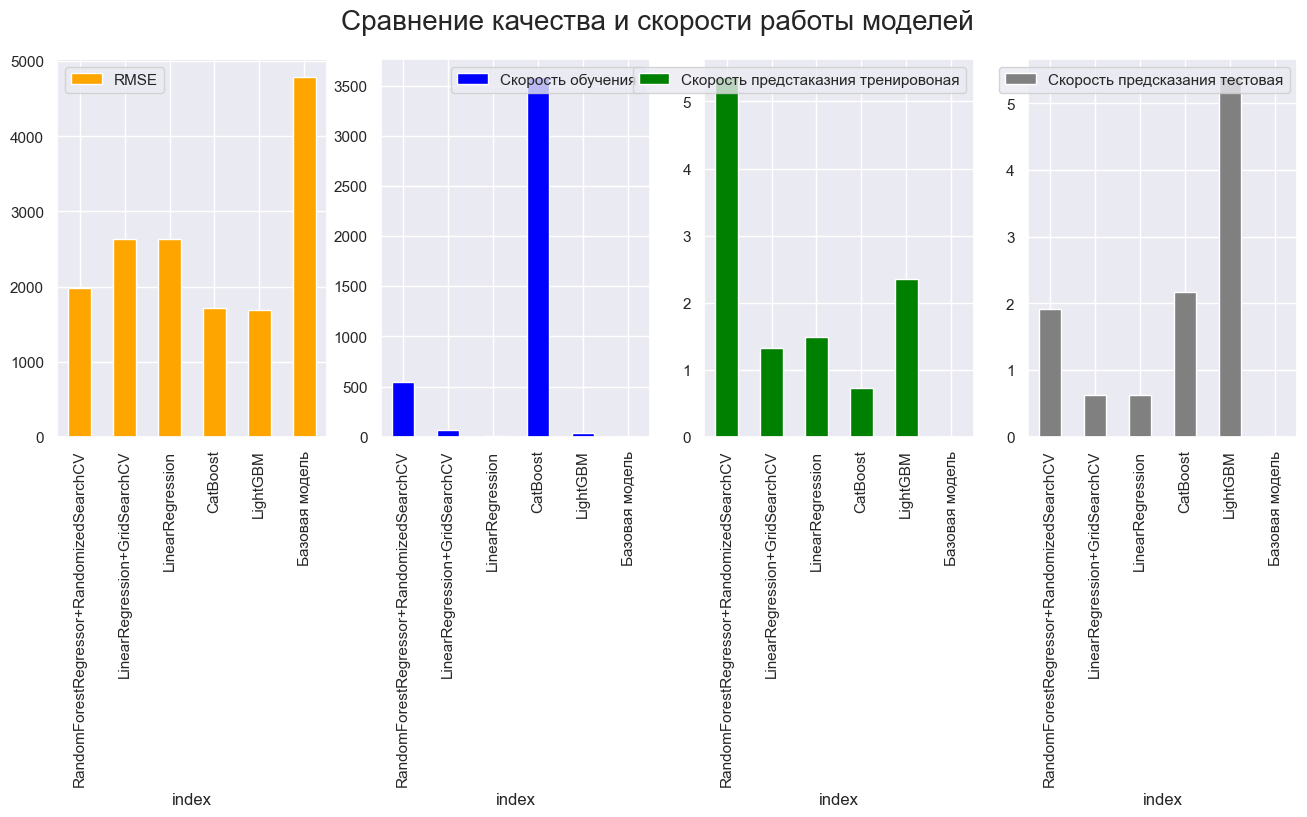

In [71]:
fig, axs = plt.subplots(1,4)

compare_models.plot(kind='bar', x='index', y= 'RMSE',color='orange', label='RMSE',ax=axs[0])
compare_models.plot(kind='bar', x='index', y= 'learn_train',color='blue', label='Скорость обучения', ax=axs[1])
compare_models.plot(kind='bar', x='index', y= 'predict_train',color='green',label='Скорость предстаказния тренировоная', ax=axs[2])
compare_models.plot(kind='bar', x='index', y= 'predict_valid',color='grey', label='Скорость предсказания тестовая',ax=axs[3])

fig.suptitle('Сравнение качества и скорости работы моделей',fontsize=20)

### Вывод

Сравнив модели, отмечу, качество работы у всех моделей существенно выше, чем у базовой и разброс метриках несущественный. В тоже время, исходя из данных и визуализации видно, что скорость обучени и предсказаний заметно отличаются.

## Общий вывод

Для выполнения задания заказчика, была проведена работа с четырьмя моделями на предврительно обработанных данных (заполнение пропусков, удаление выбрасов, кодировка, удаление дубликатов).<br>
Для обучения я выбрала четыре модели, каждой из которых были заданы различные параметры для обучения. После перебора параметров, обучения и предстказания на лучших значениях получились такие результаты:
1. Наименьшее значение метрики (RMSE - корень из средней квадратичной ошибки), которое свидельтвует о хорошем качестве модели у  `LightGBM` (1690.027033) и `CatBoost` (1714.892673). Если сравнивать с базовой моделью, то результат достаточно хороший. Неполхой результат показала модель `случайного леса` (1977.307458).
2. Наимньшая скорость обучения на лучших параметрах была у линейной модели (11.514703 сек.) и LightGBM (38.117956сек.), при этом  `CatBoost` (модель хорошим качеством) обучалась очень долго - 3582.617218 сек.
3. Лучшая скорость предстказания у линейных моделей и случайного леса.
4. Отмечу, что алгоритмы градиентного бустинга более переучены, чем линейные.
<br>
<br>
Исходя из указанного, а также приоритетав заказчика порекомендую использовать модель `LightGBM`, поскольку у неё на подобранных параметрах лучший показатель качества и довольно высокая скорость обучения, что сответвует требованиям к модели. Скорость предсказания в этом случае самая низкая (5.392647), однако, по моему мнению, качество и скорость обучения компенсируют этот недостаток. 
